<a href="https://colab.research.google.com/github/GabrielCostaDeOliveira/faceDetectionTraining/blob/main/faceDetectionDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from fastai.vision.all import *
import numpy as np

# Treino

Definindo o `path` para o dataset.

In [2]:
path = Path(os.path.join(os.getcwd(), '..', 'dataset')) # Pega o path onde o python será executado, volta e seleciona o dataset
Path.BASE_PATH = path # Muda a raiz do path para o dataset
path.ls()

(#3) [Path('wider_face_split'),Path('WIDER_train'),Path('WIDER_val')]

Verificando se as imagens não foram corrompidas

In [3]:
images = get_image_files(path) # retorna todos os caminho de imagens

Eliminando as imagens que falharam

In [4]:
# failed = verify_images(images) # retorna os caminho para imagens com falhas
# print(failed)
# failed.map(Path.unlink) # Para cada caminho, exclui o arquivo associado

Definindo funções auxiliares para recuperar as anotações das imagens dado seu _path_
Variáveis dependentes dos dados

In [5]:
# Retorna o caminho dentro da pasta annotations para as anotações de cada imagem
# caminho retira o formato da imagem (.jpg)
#
#
# Ex de path:
# /home/adriansl/unb/2022_1/ml/faceDetectionTraining/dataset/WIDER_val/images/0--Parade/0_Parade_marchingband_1_20.jpg
# split = [
#   '/home/adriansl/unb/2022_1/ml/faceDetectionTraining/dataset/WIDER_val/',
#   '/0--Parade/0_Parade_marchingband_1_20.jpg'
# ]
def img2bbox_path(path: Path):
    return 'annotations'.join(str(path).rsplit('images', 1))[:-4] # split pela direita

# Retorna um array numpy com n linhas dos dados de cada rosto
# [`left`, `top`, `width`, `height`].
# lê os dados dos arquivos annotations gerados pelo script 
# create_annotations.py (executado antes do notebook)
def get_annotation_values(path: Path):
    # with lida com tratamento de exceções e garbage collection
    # de forma padronizada pelo próprio objeto
    # Utiliza fases de execuçaçao
    with open(img2bbox_path(path), 'r', encoding='utf-8') as f:
        # para cada linha do annotation daquela imagem, 
        # cria uma lista com os dados
        #
        # faz split de cada inteiro da linha
        # operador * faz o spreading (separação) dos itens do map
        return np.array([[*map(int, s.split())] for s in f.readlines()])

Função para recuperar a bounding box de uma imagem dado seu caminho

**Recupera** somente os 4 primeiros valores (bounding box )
**[`left`, `top`, `width`, `height`].**

In [6]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return ctr[:,:4]
    return []

Visualizando um exemplo de imagem com sua bounding box

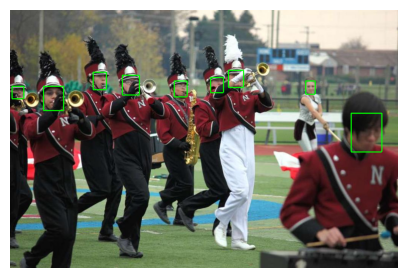

In [7]:
img = plt.imread(images[0]).copy()
for x,y,w,h in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y-1:y+2,x:x+w] = color
    img[y:y+h,x-1:x+2] = color
    img[y+h-1:y+h+2,x:x+w] = color
    img[y:y+h,x+w-1:x+w+2] = color
show_image(img);

A fastai espera a bounding box no formato [`left`, `top`, `right`, `bottom`].

Porém o nosso dataset utiliza no formato [`left`, `top`, `width`, `height`].

Então precisamos converter a bounding box para o formato da fastai. Para isso vamos alterar a função `get_bbox` definida anteriormente.

In [8]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [[x, y, x + w - 1, y + h - 1] for x, y, w, h in ctr[:,:4]]
    return []

apresentando a mesma imagem com o novo formato da bounding box

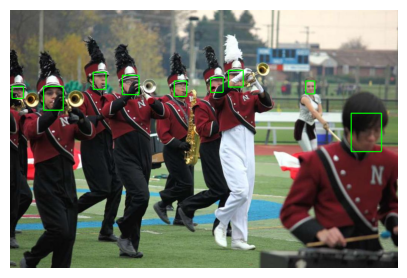

In [9]:
img = plt.imread(images[0]).copy()
for x1,y1,x2,y2 in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y1-1:y1+2,x1:x2] = color
    img[y1:y2,x1-1:x1+2] = color
    img[y2-1:y2+2,x1:x2] = color
    img[y1:y2,x2-1:x2+2] = color
show_image(img);

Função para recuperar os labels de uma imagem dado seu _path_
Label além do boundind box, verifica se a face tem algum tipo de obstrução.

In [10]:
vocab = ['no occlusion', 'partial occlusion', 'heavy occlusion']
# vocab = ['\n', '\t', '\r']

In [11]:
def get_label(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [vocab[x] for x in ctr[:,-2]]
    return []

In [12]:
def custom_get_image_files(o):return list(filter(get_label, get_image_files(o)))
images = custom_get_image_files(path)[:320]

In [13]:
data_block = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    get_items=lambda o: images,
    # noop == no-operation, já que ImageBlock já retorna a imagem do caminho para o batch
    # utilizanfo PILBase.create
    # funcções separadas para as variáveis dependentes do BBox e para as labels
    getters=[noop, get_bbox, get_label],
    # Como o dado já está separado em validação, a função verifica se 
    # o caminho ../../../nome_da_pasta termina com 'val':
    # splitter=FuncSplitter(lambda o: o.parent.parent.parent.name.endswith('val')),
    item_tfms=Resize(224, method='squish'),
    batch_tfms=[*aug_transforms(min_scale=1.0), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
# Testes iniciais com o datablock
data_block.summary(path)

Setting-up type transforms pipelines
Found 320 items
2 datasets of sizes 256,64
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_bbox -> TensorBBox.create
Setting up Pipeline: get_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}

Building one sample
  Pipeline: PILBase.create
    starting from
      c:\Users\Thalisson\prog\aulas\ml\faceDetectionTraining\src\..\dataset\WIDER_train\images\0--Parade\0_Parade_Parade_0_325.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1024x512
  Pipeline: get_bbox -> TensorBBox.create
    starting from
      c:\Users\Thalisson\prog\aulas\ml\faceDetectionTraining\src\..\dataset\WIDER_train\images\0--Parade\0_Parade_Parade_0_325.jpg
    applying get_bbox gives
      [[26, 10, 32, 20], [33, 16, 41, 28], [39, 7, 46, 15], [56, 6, 64, 18], [68, 19, 74, 28], [62, 18, 67, 28], [18, 26, 23, 41], [20, 45, 28, 57], [27, 65, 41, 81], [19, 75, 29, 89], [68, 49, 76, 57], [89, 0, 97, 12], [109, 33, 120, 48], [124, 

Como podemos ver, nosso dataset é possui `12880` itens para treino e `3226` para validação.

In [14]:
datasets = data_block.datasets(path)

len(datasets.train), len(datasets.valid)

(256, 64)

Onde cada item é composto por uma imagem (a variável independente), uma tensor de bounding boxes e um tensor de multi categorias (que juntos compõem as variáveis dependentes).

In [15]:
datasets.train[0]

(PILImage mode=RGB size=1024x684,
 TensorBBox([[756., 252., 796., 303.],
             [826., 271., 847., 306.],
             [705., 307., 749., 358.],
             [597., 355., 634., 404.],
             [496., 247., 535., 293.],
             [485., 176., 530., 225.],
             [446., 125., 473., 166.],
             [446., 338., 489., 385.],
             [280., 350., 320., 398.],
             [273., 200., 303., 246.],
             [191., 267., 221., 311.],
             [189., 323., 217., 371.],
             [683., 241., 716., 288.],
             [ 92., 382., 117., 426.],
             [ 17., 409.,  54., 451.],
             [ 42., 383.,  67., 421.],
             [  7., 644.,  41., 683.],
             [594., 242., 626., 278.]]),
 TensorMultiCategory([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1]))

In [16]:
data_loaders = data_block.dataloaders(path)
data_loaders.vocab

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


['#na#', 'heavy occlusion', 'no occlusion', 'partial occlusion']

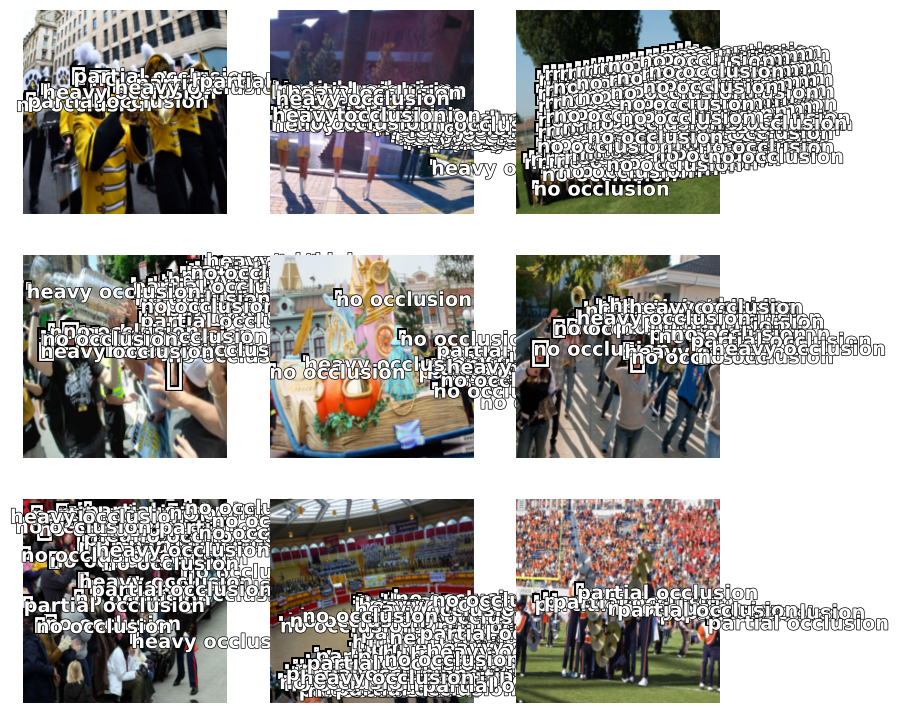

In [17]:
data_loaders.show_batch()

As coordenadas das bounding boxes são re-escaladas para valores entre -1 e 1

In [18]:
one_batch = data_loaders.one_batch()
one_batch[1][0][0]

TensorBBox([0.8977, 0.2730, 0.9283, 0.3206], device='cuda:0')

In [19]:
len(one_batch[2][0])

811

In [20]:
from fastai.vision.models.unet import _get_sz_change_idxs, hook_outputs

def conv2d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init=nn.init.kaiming_normal_):
    "Create and initialize `nn.Conv2d` layer."
    if padding is None: padding = ks // 2
    return init_default(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sz_change_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [ConvLayer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [21]:
body = create_body(resnet34(True))
model = RetinaNet(body, 3, final_bias=-4)

c:\Users\Thalisson\prog\aulas\ml\.venv\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Thalisson\prog\aulas\ml\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [23]:
model.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [24]:
model.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [25]:
model.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [26]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else torch.tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else torch.tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    return matches

def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

def IoU_values(anchs, targs):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchs, targs)
    anc_sz, tgt_sz = anchs[:,2] * anchs[:,3], targs[:,2] * targs[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

class RetinaNetFocalLoss(nn.Module):
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales=None, ratios=None, reg_loss=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

class SigmaL1SmoothLoss(nn.Module):
    def forward(self, pred, targ):
        reg_diff = torch.abs(targ - pred)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

In [27]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [28]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [29]:
learn = Learner(data_loaders, model, loss_func=crit, splitter=_retinanet_split)

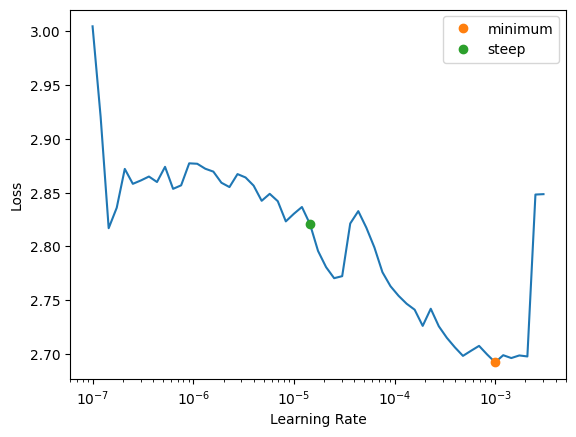

In [30]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [31]:
print(lr_min, lr_steep)

0.00010000000474974513 1.4454397387453355e-05


In [32]:
learn.fine_tune(10, freeze_epochs=3, base_lr=lr_steep)

In [33]:
learn.eval()

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [34]:
learn.export()

# Inferência

In [ ]:
# learn = load_learner('export.pkl')

In [ ]:
# b = data_loaders.valid.one_batch()
# q, w, c = learn.get_preds(dl=[b], with_decoded=True)

In [35]:
learn.show_results()

AttributeError: Exception occured in `GatherPredsCallback` when calling event `after_validate`:
	'int' object has no attribute 'index_select'

In [ ]:
def draw_bbox(img, bbox, offset=0):
    x,y,w,h = map(int, bbox)
    color = np.array([255, 0, 0], dtype=np.uint8)
    img[y-offset:y+offset,x:x+w] = color
    img[y:y+h,x-offset:x+offset] = color
    img[y+h-offset:y+h+offset,x:x+w] = color
    img[y:y+h,x+w-offset:x+w+offset] = color


In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects
import cv2

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    # ax.set_xticks(np.linspace(0, 224, 8))
    # ax.set_yticks(np.linspace(0, 224, 8))
    # ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    im = (im + 1) / 3
    im = im.numpy()
    k=0
    texts = []
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>1) and (pr is None or pr > thresh)):
            k+=1
            draw_bbox(im, b, 1)
            # draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{k}: '
            if c is not None: txt += ('bg' if c==0 else data_loaders.vocab[c])
            if pr is not None: txt += f' {pr:.2f}'
            texts.append((b, txt))
            # draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            # im = cv2.putText(im.copy(), txt, b[:2], cv2.FONT_HERSHEY_SIMPLEX, 1, (120,120,10), 1, 2)

    rotated_im = np.rot90(im, 3)
    for b, txt in texts:
        rotated_im = cv2.putText(rotated_im.copy(), txt, b[-2:], cv2.FONT_HERSHEY_SIMPLEX, .5, (255,0,0), 1, 1)

    ax = show_img(rotated_im, ax=ax)

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [ ]:
one_batch = data_loaders.valid.one_batch()
y = one_batch[1:]
learn.model.eval()
pred = learn.model(one_batch[0])
b_clas, b_bb = pred
x = one_batch[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

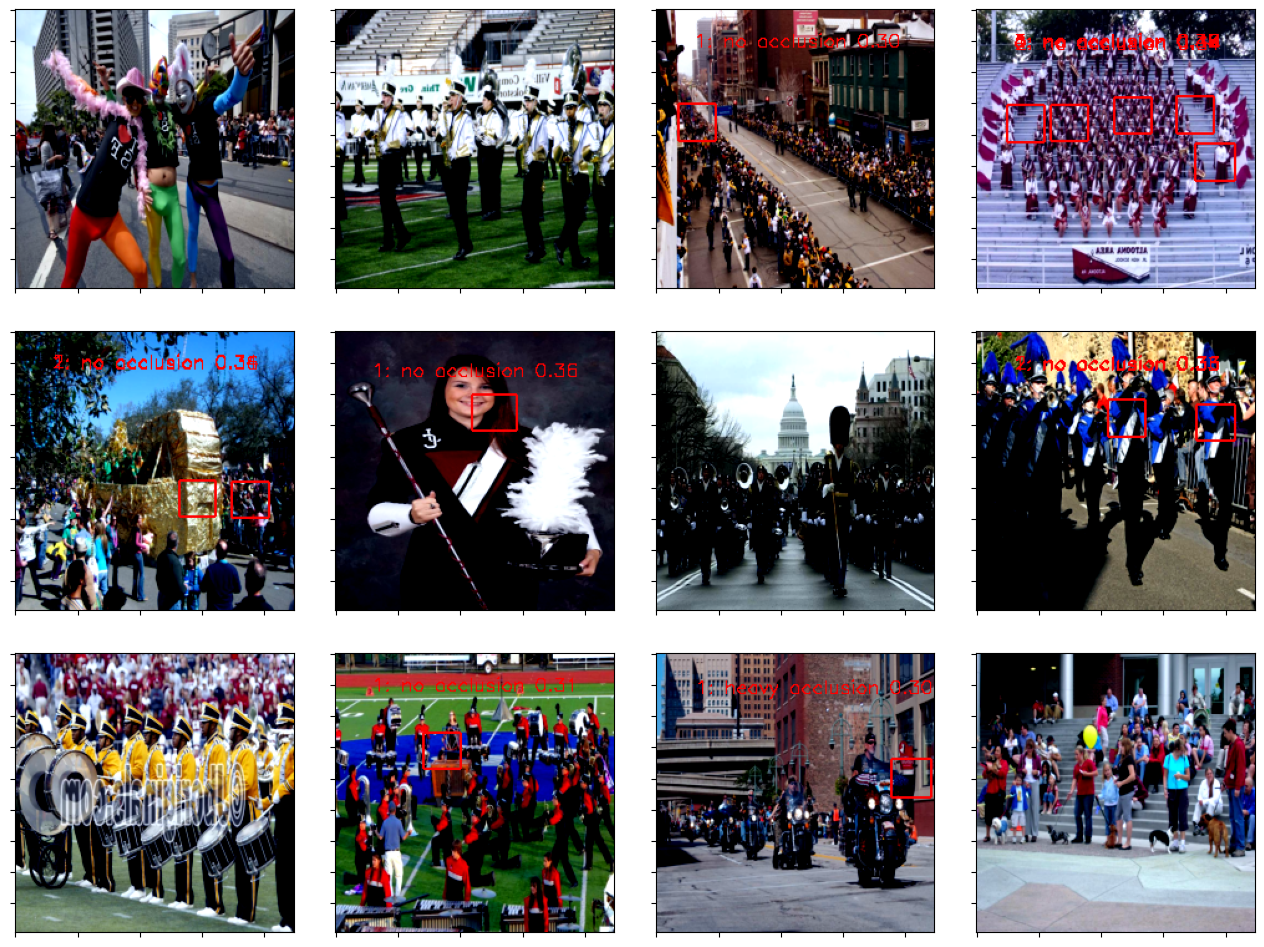

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima = x.permute(0,3,2,1).cpu()[idx]
#     ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), thresh=0.3)
plt.subplots_adjust(wspace=0.15, hspace=0.15)

In [ ]:
# one_batch = data_loaders.valid.one_batch()
# y = one_batch[1:]
# x = one_batch[0].permute(0,3,2,1).cpu()
# ## Bounding Box after dataloader should Rescale
# fig, axes = plt.subplots(3, 4, figsize=(16, 12))
# for i,ax in enumerate(axes.flat):
#     show_ground_truth(ax, x[i].cpu(), ((y[0][i]+1)/2*224).cpu(), y[1][i].cpu())
# plt.tight_layout()